# Linear Scaling BigDFT: Beyond Default Parameters

In this notebook, we will explore some of the capabilites and behaviour of linear scaling BigDFT, going beyond the default parameters from the ```import: linear``` profile, using the example of glycine.

This tutorial assumes that you are familiar with the basics of PyBigDFT and BigDFT, as well as the quick start linear scaling tutorial.

## Support Function Parameters

### Cubic vs Linear

Previously, we saw how to run linear scaling (LS) BigDFT, now let's see how the results compare to cubic scaling (CS) BigDFT. For this tutorial, we will take the example of glycine. Let's read in and visualise the system.

In [37]:
from BigDFT.Visualization import InlineVisualizer
from BigDFT.Systems import System
from BigDFT.IO import read_xyz

# first we read in the molecule
name = 'glycine1'
ifile = open(name+'.xyz')
# we aren't going to use fragments for this tutorial, so we will read in the system as a single fragment
gly1 = read_xyz(ifile, fragmentation='single')
ifile.close()

# then we can visualise it
viz = InlineVisualizer(300, 300)
viz.display_system(gly1, zoom=1.5)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Now let's set up our cubic and linear scaling input files, using the default linear profile as before.

In [2]:
from BigDFT.Inputfiles import Inputfile

inpc = Inputfile()
inpl = Inputfile()

for inp in [inpc, inpl]:
    inp.set_hgrid(0.5)
    inp.set_psp_nlcc()
    inp.set_xc("PBE")

inpl["import"] = "linear"

And now let's setup the BigDFT calculator and run both calculations.

In [3]:
from BigDFT.Calculators import SystemCalculator

Ha2eV = 27.211396132

calc = SystemCalculator(omp=2, mpi_run='mpirun -n 2', skip=True, verbose=False)

run_cubic = calc.run(input=inpc, name=name+'_cubic', posinp=name+'.xyz')
cubic_energy = Ha2eV * run_cubic.energy / run_cubic.nat
cubic_time = run_cubic.log['Timings for root process']['Elapsed time (s)'] / 60.0   

print('Cubic scaling calculation took '+'{0:.1f}'.format(cubic_time)+' minutes, E = '+\
      '{0:.3f}'.format(cubic_energy)+' eV/atom')

run_linear = calc.run(input=inpl, name=name+'_linear', posinp=name+'.xyz')
linear_energy = Ha2eV * run_linear.energy / run_linear.nat
linear_time = run_linear.log['Timings for root process']['Elapsed time (s)'] / 60.0   
                    
print('Linear scaling calculation took '+'{0:.1f}'.format(linear_time)+' minutes, E = '+\
      '{0:.3f}'.format(linear_energy)+' eV/atom, E_linear - E_cubic = '+\
      '{0:.1f}'.format(1000.0 * (linear_energy - cubic_energy))+' meV/atom')

Cubic scaling calculation took 0.1 minutes, E = -161.852 eV/atom
Linear scaling calculation took 1.1 minutes, E = -161.816 eV/atom, E_linear - E_cubic = 35.5 meV/atom


Here we can notice two things:
- The LS calculation takes much longer than the CS calculation. This is because the system is well below the crossover point.
- The LS calculation has a higher energy than the CS calculation. 

However, the absolute energy difference is not very informative, so let's try running a different conformer of glycine, and see how the _relative_ energies compare.

First let's visualise the two conformers side by side, so we can see the differences.

In [38]:
name2 = 'glycine2'
ifile = open(name2+'.xyz')
gly2 = read_xyz(ifile, fragmentation='single')
ifile.close()

molecules = []
molecules.append(gly1)
molecules.append(gly2)
gridlist = [[0, 0], [0, 1]]
colordict = [{"FRA:0": '#FF0000'}, {"FRA:0": '#0000FF'}]
viz = InlineVisualizer(300, 300, nrow=1, ncol=2)
viz.display_system(*molecules, gridlist=gridlist, colordict=colordict, zoom=1.5)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [5]:
run_cubic2 = calc.run(input=inpc, name=name2+'_cubic', posinp=name2+'.xyz')
deltae_cubic = Ha2eV * (run_cubic2.energy - run_cubic.energy)

print('Cubic scaling Delta E = '+'{0:.3f}'.format(deltae_cubic)+' eV')

run_linear2 = calc.run(input=inpl, name=name2+'_linear', posinp=name2+'.xyz')
deltae_linear = Ha2eV * (run_linear2.energy - run_linear.energy)
   
error = (deltae_linear - deltae_cubic) / run_cubic.nat                 
print('Linear scaling Delta E = '+'{0:.3f}'.format(deltae_linear)+' eV, Delta E_linear - Delta E_cubic = '+\
      '{0:.1f}'.format(1000.0 * (error))+' meV/atom')

Cubic scaling Delta E = 0.098 eV
Linear scaling Delta E = 0.118 eV, Delta E_linear - Delta E_cubic = 1.9 meV/atom


As you can see, we benefit significantly from error cancellation, despite the fact that the support function optimisation means the basis set is not identical between the two conformers.

### Convergence

In many cases, the accuracy of the default linear profile is already sufficient. However, we may sometimes wish to push the accuracy further. In order to understand how, let's look at the input file in more detail.

The support function (SF) basis is defined by a number of key parameters, which we can see if we inspect the ```lin_basis_params``` section of the logfile. Let's take a look.

In [6]:
# the basis params are defined on a per-element basis, with a default value for unlisted elements
# let's just look at the elements which are in glycine
elements = ['H', 'C', 'N', 'O']
for element in elements:
    print(element, run_linear.log['lin_basis_params'][element])

H {'nbasis': 1, 'rloc': 5.0}
C {'nbasis': 4, 'rloc': 5.5}
N {'nbasis': 4, 'rloc': 5.5}
O {'nbasis': 4, 'rloc': 5.5}


As you can see, here we have a minimal basis, with only _s_-like SFs for H, and both _s_ and _p_-like SFs for C, N, O. You can also see that the localisation radii is smaller for H than for the other elements. If we want to increase the accuracy of our LS calculation, we can vary rloc.

For simplicity, let's set all the elements to have the same localisation radius, and see how the total energy converges with repect to increasing localisation radius.

Note that for larger localisation radii, it's also necessary to increase both ```rloc_kernel``` and ```rloc_kernel_foe```,  which define the localisation radii for the density kernel and the matrix vector muliplications used by the Fermi Operator Expansion approach. Both variables are also part of ```lin_basis_params```.

In [7]:
# define a range of sensible values -- too small and the results will be nonsensical
rlocs = range(5, 10)

rloc_runs = []
for rloc in rlocs:
    # define the input dictionary depending on the value of rloc
    inpl.update({'lin_basis_params': {'H': {'nbasis': 1, 'rloc': rloc},
                                     'C': {'nbasis': 4, 'rloc': rloc},
                                     'N': {'nbasis': 4, 'rloc': rloc},
                                     'O': {'nbasis': 4, 'rloc': rloc}}})
    
    # run LS-BigDFT, saving the run to a list
    rloc_runs.append(calc.run(input=inpl, name=name+'_rloc'+str(rloc), posinp=name+'.xyz'))
    
    print('Calculation with rloc = '+str(rloc)+' is complete')

Calculation with rloc = 5 is complete
Calculation with rloc = 6 is complete
Calculation with rloc = 7 is complete
Calculation with rloc = 8 is complete
Calculation with rloc = 9 is complete


Let's plot the total energy convergence, using the cubic scaling energy as a reference.

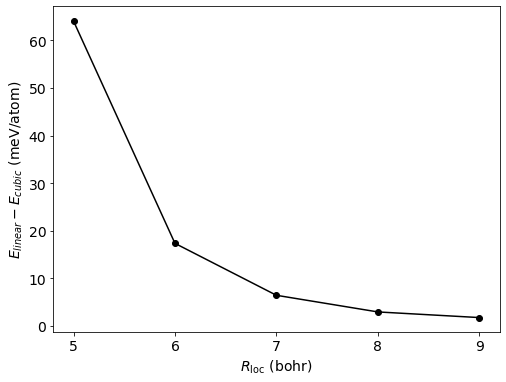

In [8]:
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(rlocs, [1000.0 * Ha2eV * (run.energy - run_cubic.energy)/run.nat for run in rloc_runs],
        color='k', marker='o')

ax.set_ylabel('$E_{linear} - E_{cubic}$ (meV/atom)')
ax.set_xlabel('$R_{\mathrm{loc}}$ (bohr)')

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

As we can see, the error decreases monotonically with the localisation radius, being less than a few meV/atom for the largest radii.

It's also interesting to see how the time varies. Let's generate a table summarising both the energies and timings.

In [9]:
import pandas as pd
from IPython.display import display

rows = ['LS, rloc='+str(rloc)+' bohr' for rloc in rlocs]
rows += ['CS']
columns = ['Total Energy (eV)', 'Error (meV/atom)', 'Total Time (min.)']

table_data = []

for run in rloc_runs:
    table_data.append([Ha2eV * run.energy, 1000.0 * Ha2eV * (run.energy - run_cubic.energy) / run.nat,
                 run.log['Timings for root process']['Elapsed time (s)'] / 60.0])
    
table_data.append([Ha2eV * run_cubic.energy, 0.0, cubic_time])

table = pd.DataFrame(table_data, index=rows, columns=columns)

table.round(2)

,Total Energy (eV),Error (meV/atom),Total Time (min.)
"LS, rloc=5 bohr",-1617.88,64.07,1.34
"LS, rloc=6 bohr",-1618.34,17.35,1.08
"LS, rloc=7 bohr",-1618.45,6.44,1.27
"LS, rloc=8 bohr",-1618.49,2.94,1.32
"LS, rloc=9 bohr",-1618.50,1.75,1.21
CS,-1618.52,0.00,0.11


Here we see that the walltime does not vary as systematically as the energy. This is because, while the cost of a given operation may increase due to larger localisation radii, the number of iterations may sometimes decrease when using larger radii. 

This behaviour is also very system dependent, since for this system size the matrices are fully dense, whereas for larger systems the sparsity pattern will influence the computational cost.

### Exercise

- Using the same input file, vary the localisation radius for the second glycine conformer. Use the same naming scheme, i.e. the runs should be called 'glycine2_rloc{r}.yaml', where r is the localisation radius.

In [10]:
rloc_runs2 = []
for rloc in rlocs:
    inpl.update({'lin_basis_params': {'H': {'nbasis': 1, 'rloc': rloc},
                                     'C': {'nbasis': 4, 'rloc': rloc},
                                     'N': {'nbasis': 4, 'rloc': rloc},
                                     'O': {'nbasis': 4, 'rloc': rloc}}})
    
    rloc_runs2.append(calc.run(input=inpl, name=name2+'_rloc'+str(rloc), posinp=name2+'.xyz'))
    
    print('Calculation with rloc = '+str(rloc)+' is complete')

Calculation with rloc = 5 is complete
Calculation with rloc = 6 is complete
Calculation with rloc = 7 is complete
Calculation with rloc = 8 is complete
Calculation with rloc = 9 is complete


- Plot the convergence in the error of the _relative_ energies, again using the cubic scaling values as a reference.

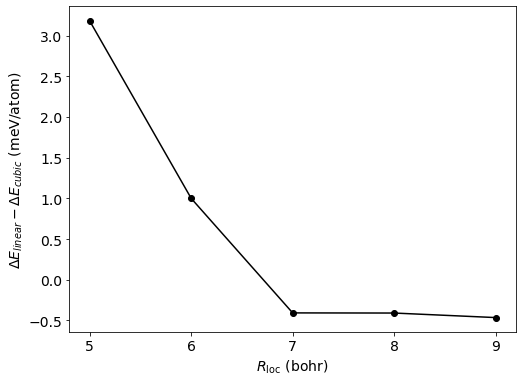

In [11]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(rlocs, [1000.0 * Ha2eV * ((rloc_runs2[r].energy - rloc_runs[r].energy) \
                                  - (run_cubic2.energy - run_cubic.energy))/run.nat 
                                  for r,rloc in enumerate(rlocs)], color='k', marker='o')

ax.set_ylabel('$\Delta E_{linear} - \Delta E_{cubic}$ (meV/atom)')
ax.set_xlabel('$R_{\mathrm{loc}}$ (bohr)')

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

You should find that the errors are much smaller than for the total energies, regardless of the localisation radius.

You may also notice that the error does not tail off exactly to zero. This small error can be reduced by fine-tuning other parameters, such as the convergence thresholds.

In additon, as well as varying the localisation radii, we can also increase the number of SFs associated with each species. This can be useful in the case of heavier elements, either to ensure better convergence or guided by the pseudopotential definition, as well as for excited state simulations, as discussed in the tutorial on transition-based constrained DFT. But for most systems containing only light elements, a minimal basis will be sufficient.

It is also possible to change parameters relating to the SF opimisation, including the convergence threshold, number of SF optimisation iterations etc. These are defined in the ```lin_basis``` input block, and the default values are printed below. In most cases (with the exception of fragment calculations, as we will see in later tutorials), it will not be necessary to adapt any of the parameters.

In [12]:
print(run_linear.log['lin_basis'])

{'nit': 8, 'idsx': 8, 'gnrm_cv': 0.002, 'deltae_cv': 0.0001, 'min_gnrm_for_dynamic': 0.004, 'alpha_diis': 0.5, 'alpha_sd': 0.5, 'nstep_prec': 6, 'fix_basis': 1e-12, 'correction_orthoconstraint': 0, 'gnrm_ig': 0.1, 'reset_DIIS_history': True, 'nit_ig': 50, 'extended_ig': False, 'orthogonalize_sfs': True, 'gnrm_dyn': 0.0001, 'orthogonalize_ao': True}


## Density Kernel Parameters

As well as the SF optimisation, we can also adjust the parameters relating to density kernel optimisation, which are defined in the ```lin_kernel``` block.

Of these, one of the most important parameters is the approach used for kernel optimisation, which is set using the ```linear_method``` keyword.

The linear scaling profile uses the Fermi Operator Expansion (```FOE```) approach, which is the recommended approach in most cases, particularly for very large systems. However, two other approaches are also available: direct minimisation of the Kohn Sham (KS) coefficients (```DIRMIN```), and diagonalisation (```DIAG```).

These other approaches may be useful in different scenarios, as we will see.

### Density of States

First let's think about plotting a density of states (DoS). The LS runs we did all used FOE, which works directly with the density kernel, not the coefficients. As a result, in a standard calculation, we don't have access to the eigenvalues. 

If we want to plot the DoS we could use the diagonalisation approach instead, or we can still use FOE, and just tell BigDFT to do a single diagonalisation at the end. Let's do that and rerun one of the calculations.

In [13]:
# turn on subspace diagonalisation
inpl.update({'lin_general': {'subspace_diag': True}})

# reset to the default rloc
inpl.pop('lin_basis_params')

run_linear_dos = calc.run(input=inpl, name=name+'_linear_dos', posinp=name+'.xyz')

We can now plot the DoS, comparing it to CS BigDFT (see the tutorial on the DoS for more information on how to extract and plot the DoS).

Note that the Fermi level is not automatically retrieved for LS-BigDFT, so we'll use the CS Fermi level.

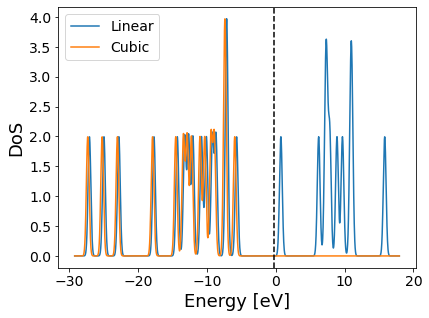

In [14]:
from BigDFT.DoS import DoS

dos = DoS(logfiles_dict={'Linear': run_linear_dos, 'Cubic': run_cubic},
          fermi_level=run_cubic.fermi_level, units='eV')

ax = dos.plot()
ax.legend(loc='best')
plt.show()

There are some small discrepancies, but overall the DoS for LS and CS are similar - as with the total energy, if better agreement is required, we could increase the localisation radii.

Notice, however, that the virtual states are missing for the CS DoS. Let's rerun CS BigDFT, telling it to also calculate some empty states.

In [15]:
# calculate 10 virtual states using the Davidson approach after the SCF cycle
# setting a subspace of 20 virtual orbitals
inpc.extract_virtual_states(nvirt=10, davidson=True, norbv=20)

run_cubic_dos = calc.run(input=inpc, name=name+'_cubic_dos', posinp=name+'.xyz')

Let's replot the DoS comparison.

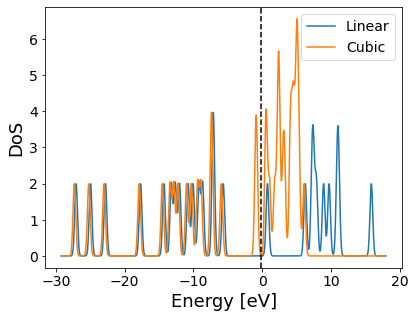

In [16]:
dos = DoS(logfiles_dict={'Linear': run_linear_dos, 'Cubic': run_cubic_dos},
          fermi_level=run_cubic.fermi_level, units='eV')

ax = dos.plot()
ax.legend(loc='best')
plt.show()

Now we have the virtual states for both approaches, we can see that the agreement above the Fermi lvel is very poor. This is expected, as the SFs have been optimised to represent the occupied states only. 

It is possible to also optimise the SFs to represent the low-lying virtual states using the direct minimisation approach, as is explained in more detail in the tutorial on transition-based constrained DFT.

As with SF optimisation parameters, the rest of the density kernel optimisation parameters can be safely kept at their default values for most calculations, except in the case of fragment calculations, as we will also see in later tutorials.

## From Linear Scaling to Cubic Scaling

Let's now briefly look at I/O in LS-BigDFT. By default, the profile will output the SF matrices (kernel, overlap etc.), however we may also wish to output the SFs themselves, either for visualisation, or for doing a restart calculation.

This is activated by using the ```output_wf``` keyword in ```lin_general```. A restart calculation can then be performed starting from these SFs, which you can see an example of in the fragment tutorials.

We also have another possibility - we can write the KS wavefunctions themselves, in a format which can be used for CS BigDFT. Let's try this now.

In [17]:
# tell BigDFT to output the KS orbitals in text format
inpl.update({'output': {'orbitals': 'text'}})

run_linear_write = calc.run(input=inpl, name=name+'_linear_write', posinp=name+'.xyz')
linear_write_energy = Ha2eV * run_linear_write.energy / run_linear_write.nat
linear_write_time = run_linear_write.log['Timings for root process']['Elapsed time (s)']

print('Linear scaling calculation took '+'{0:.1f}'.format(linear_write_time)+' seconds, E = '+\
      '{0:.4f}'.format(linear_write_energy)+' eV/atom')

# and then run CS BigDFT using this as an input, without any further optimisation
inpc['dft'].update({'inputpsiid': 2, 'itermax': 1}) 
# we also need to tell CS BigDFT what directory the files are in
inpc.update({'radical': name+'_linear_write'})
# and let's turn off the virtual states
inpc.extract_virtual_states(nvirt=0)

run_cubic_read = calc.run(input=inpc, name=name+'_cubic_read', posinp=name+'.xyz')
cubic_read_energy = Ha2eV * run_cubic_read.energy / run_cubic_read.nat
cubic_read_time = run_cubic_read.log['Timings for root process']['Elapsed time (s)']

print('Cubic scaling calculation took '+'{0:.1f}'.format(cubic_read_time)+' seconds, E = '+\
      '{0:.4f}'.format(cubic_read_energy)+' eV/atom')

Linear scaling calculation took 73.3 seconds, E = -161.8162 eV/atom
Cubic scaling calculation took 1.0 seconds, E = -161.8164 eV/atom


You can see that the two calculations have very similar energies, apart from a small numerical discrepancy, but since we did not further optimise the KS orbitals, the cubic scaling calculation was very quick.

## Linear Scaling BigDFT and HPC

In this notebook the calculations were performed only using a handful of cores, however for most interesting systems where LS-BigDFT is applicable, we will be using supercomputers, with very many cores. There are a few extra points to bear in mind for such calculations:
- GPUs: Not available with LS-BigDFT.
- OpenMP: Up to 8 threads can typically be used without too large a loss of efficiency, but for low memory nodes it may be necessary to use more threads to avoid under-occupying a node.
- MPI: MPI tasks are primarily parellelised over SFs (also in places over KS orbitals as in CS-BigDFT), so there is a strict maximum upper limit of MPI tasks which can be used. For best performance, it is better to have at leat 5-10 SFs per MPI.

We can check the parallelisation setup by inspecting the logfile:

In [18]:
print('MPI tasks = ',run_linear.log['Number of MPI tasks'])
print('OpenMP threads = ',run_linear.log['Maximal OpenMP threads per MPI task'])

print('Orbitals repartition', run_linear.log['Orbitals Repartition'])
print('Support function repartition',run_linear.log['Support Function Repartition'])

MPI tasks =  2
OpenMP threads =  2
Orbitals repartition {'MPI tasks  0- 0': 8, 'MPI tasks  1- 1': 7}
Support function repartition {'Minimum': 12, 'Maximum': 13, 'Average': 12.5}


Here we can easily see that we have enough SFs per MPI to run efficiently, with each task having enough work and a well-balanced setup.

## When to use Linear Scaling BigDFT

As a final note, we may ask how to decide when to use LS vs CS BigDFT. This may depend on both the functionality we wish to use, e.g. hybrid functionals and _k_-points are only available in CS-BigDFT, whereas the complexity reduction framework is only compatible with LS-BigDFT.

In addition, the applicability of each method will depend on the size of the system. For small systems, CS will be cheaper due to the smaller prefactor, as we already saw in this tutorial. The crossover point at which LS becomes cheaper is system dependent and influenced by a range of factors, including band gap, dimensionality, and various input parameters such as the localisation radii. Therefore it may be important to investigate on a system-dependent basis, but as a rule of thumb, above 1000 atoms it will usually be cheaper to use LS-BigDFT.